In [1]:
# automatically upload modules
%load_ext autoreload
%autoreload 2

In [2]:
from argparse import Namespace
import os, sys
import pandas as pd
#import pickle
from ray import tune
# import ConfigSpace as CS
# from ray.tune.suggest.bohb import TuneBOHB
# from ray.tune.schedulers import HyperBandForBOHB
import torch
import argparse # for ray distributed training
import numpy as np

from genome_embeddings import data_viz
from genome_embeddings import evaluate
from genome_embeddings import models
from genome_embeddings import train_test
from genome_embeddings import util
from genome_embeddings import analyze_model
#from genome_embeddings import trainable # import before ray (?)
import ray

In [ ]:
# os.system("rm file_out")
# os.system("rm file_err")

# sys.stdout = open('file_out', 'w')
# sys.stderr = open('file_err', 'w')

In [3]:
# settings = Namespace(
#     DATA_FP = '/home/ndudek/projects/def-dprecup/ndudek/',
#     SAVE_FP = '/home/ndudek/projects/def-dprecup/ndudek/',
#     num_epochs = 10,
#     num_cpus=20)

settings = Namespace(
    DATA_FP = '/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_embeddings/data/', 
    SAVE_FP = '/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_embeddings/',
    num_epochs = 2,
    num_cpus=5)

In [4]:
flags = Namespace(
    KEGG_FP = '/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/kegg_dataset/',
    data_source = 'kegg', #['get_homologues' | 'kegg']
    n_test = 0.1, # train-test split, n * 100 = % of data that goes into test set (e.g.: 0.1 -> 10%)
    batch_size = 128,
    lr = 1e-3,
    kfolds = 10, # number of folds for cross-validation
    print_every = 50, # print loss every n batches during training (5)
    replacement_threshold = 0.5, # probability over which binarizer converts to a 1
    num_corruptions = 100, # number of corrupted versions of a genome to produce
    corruption_fraction = 0.5, # fraction of genes to retain during corruption process
    phy_mode = "bacteria_only", # training with only bacteria vs also euk/arch
    cirriculum = False, # implement cirriculum learning based on gene count
    rare_threshold = 10, # drop features that occur fewer than this times in training ds 
    weight_decay=0.1 # L2 regularization
    )

In [5]:
print('done loading modules and setting Namespace variables')

done loading modules and setting Namespace variables


### Data exploration + preprocessing 

In [ ]:
# # First create genome representations (very slow)
# # Each genome is a list of KO's and/or KEGG modules
# if os.path.isfile(settings.DATA_FP+'genome_to_mod.csv'):
#     print("Genome representations already exist")
# else:
#     genome_rep.genome_kos(flags.KEGG_FP)
#     print("Must generate genome representations from scratch. This will take several hours.")

In [6]:
df, unf_cluster_names = util.load_data(settings.DATA_FP, flags.data_source)
genome_to_tax = util.genome_to_tax(df)
#np.save(settings.DATA_FP+'genome_to_tax.npy', genome_to_tax) 

In [ ]:
#data_viz.tax_distrib(df, genome_to_tax)

In [ ]:
#data_viz.module_stats(df)

In [ ]:
#data_viz.genes_per_genome(df)

In [7]:
genome_to_num ={}
for i,genome in enumerate(df.index):
    genome_to_num[genome] = i

num_to_genome = {v: k for k, v in genome_to_num.items()}

In [22]:
# train_orig = pd.read_csv(settings.DATA_FP+"uncorrupted_train_balanced.csv", index_col=0)
# test_orig = pd.read_csv(settings.DATA_FP+"uncorrupted_test_balanced.csv", index_col=0) 

In [ ]:
# # Split train-test sets in a phylogenetically balanced manner 
# if os.path.isfile(settings.DATA_FP+'uncorrupted_train_balanced.csv'):
#     print("Train-test split already exists, loading from file")
#     train_orig = pd.read_csv(settings.DATA_FP+"uncorrupted_train_balanced.csv", index_col=0)    
#     test_orig = pd.read_csv(settings.DATA_FP+"uncorrupted_test_balanced.csv", index_col=0)    

# else:
#     # Create dict mapping each genome to a unique numerical ID
#     genome_to_num ={}
#     for i,genome in enumerate(df.index):
#         genome_to_num[genome] = i

#     num_to_genome = {v: k for k, v in genome_to_num.items()}
        
#     print("Generating train-test split")
#     train_orig, test_orig = util.balanced_split(df, flags.n_test, genome_to_tax, 
#                                                 num_to_genome, settings.DATA_FP)    
#     train_orig.to_csv(settings.DATA_FP+'uncorrupted_train_balanced.csv')
#     test_orig.to_csv(settings.DATA_FP+'uncorrupted_test_balanced.csv')

In [ ]:
#data_viz.hist_prob_ko(train_orig)

In [23]:
# if flags.phy_mode == "bacteria_only":
#     train_genomes = train_orig.index.to_list()
#     test_genomes = test_orig.index.to_list()
    
#     unf_train_data, train_tax_dict = util.bacteria_only(train_orig, train_genomes, genome_to_tax)
#     unf_test_data, test_tax_dict = util.bacteria_only(test_orig, test_genomes, genome_to_tax)

In [24]:
# torch.save(test_tax_dict, settings.DATA_FP+"test_tax_dict_07-17-20.pt")

In [ ]:
# Remove rare features from train + test datasets
# Rare = fewer than n occurences in training dataset
# Last argument specifies n, set to correspond to 1% of genomes (3432 genomes -> n = 34)
# Remove genes occuring in <1.1% of genomes ---> extra 0.1 is to make there be an even number of features
#     An even number of features is essential for having the autoencoder layers work out properly
# train_data, test_data, cluster_names = util.remove_rare(unf_train_data, unf_test_data, 
#                                                         unf_cluster_names, unf_train_data.shape[0]*0.01)
# torch.save(cluster_names, settings.DATA_FP+"cluster_names_22-07-20.pt")

In [8]:
# Produce corrupted genomes
# Could eventually do re-sampling / extra-corrupting to have more examples of "rare" genome types
#    e.g.: those from underrepresented groups M00003   

if os.path.isfile(settings.DATA_FP+'corrupted_train_07-17-20.pt'):
    print("Corrupted genomes already exist")
    train_data = torch.load(settings.DATA_FP+"corrupted_train_07-17-20.pt")
    test_data = torch.load(settings.DATA_FP+"corrupted_test_07-17-20.pt")
    genome_idx_train = torch.load(settings.DATA_FP+"genome_idx_train_07-17-20.pt")
    genome_idx_test = torch.load(settings.DATA_FP+"genome_idx_test_07-17-20.pt")
    cluster_names = torch.load(settings.DATA_FP+"cluster_names_07-17-20.pt")
    test_tax_dict = torch.load(settings.DATA_FP+"test_tax_dict_07-17-20.pt")
else:
    print("Generating corrupted dataset from scratch with",flags.num_corruptions,"corrupted versions of each genome")
    train_data, genome_idx_train = util.corrupt(train_data, flags.num_corruptions, flags.corruption_fraction, 
                                                    cluster_names, "train", settings.DATA_FP)
    print("Finished training data, starting test")
    test_data, genome_idx_test = util.corrupt(test_data, flags.num_corruptions, flags.corruption_fraction, 
                                                  cluster_names, "test", settings.DATA_FP)

Corrupted genomes already exist


In [10]:
train_data.shape, test_data.shape, len(cluster_names)

(torch.Size([239500, 14130]), torch.Size([28800, 14130]), 7065)

In [ ]:
# sys.stdout.flush()
# sys.stderr.flush()

In [ ]:
#import numpy as np # this is slooooow
#np.savetxt(settings.DATA_FP+"corrupted_train_1407.txt", train_data.numpy())
#np.savetxt(settings.DATA_FP+"corrupted_test_1407.txt", test_data.numpy())

In [ ]:
# print(("There are %s genomes and %s features in the training dataset") % 
#       (train_data.shape[0],int(train_data.shape[1]/2)))

# print(("There are %s genomes and %s features in the test dataset") % 
#       (test_data.shape[0],int(test_data.shape[1]/2)))

### Define and train network

In [ ]:
# print(train_data.shape[1])

In [ ]:
# num_features = int(train_data.shape[1]/2) # Number of features in the entire dataset (train + test)

In [ ]:
# # define the network
# num_features = 7065
# model = models.AutoEncoder(num_features, 2)
# model

In [ ]:
# sys.stdout.flush()
# sys.stderr.flush()

In [ ]:
# config_space = CS.ConfigurationSpace()

# config_space.add_hyperparameter(
#     CS.CategoricalHyperparameter(name='nn_layers', choices=[1, 2])) #, 3, 4])) 

# config_space.add_hyperparameter(
#     CS.CategoricalHyperparameter(name='batch_size', choices=[32])) #, 64, 128, 256]))

# #Optimizer = Adam -- LR less important
# config_space.add_hyperparameter(
#     CS.UniformFloatHyperparameter('lr', lower=1e-4, upper=1e-1, log=True))

# config_space.add_hyperparameter(
#     CS.UniformFloatHyperparameter('weight_decay', lower=1e-5, upper=1e-2, log=True))

# algo = TuneBOHB(
#     config_space, max_concurrent=4, metric='test_f1', mode='max')

# bohb = HyperBandForBOHB(
#     time_attr='training_iteration',
#     metric='test_f1',
#     mode='max',
#     max_t=100, 
#     reduction_factor=3)

In [ ]:
# memory = 2000 * 1024 * 1024
# object_store_memory = 200 * 1024 * 1024
# driver_object_store_memory=100 * 1024 * 1024
# ray.shutdown()
# ray.init(local_mode=True, memory=memory, 
#         object_store_memory=object_store_memory,
#         driver_object_store_memory=driver_object_store_memory,
#         num_cpus=settings.num_cpus)

In [ ]:
# # config = {"num_epochs":settings.num_epochs,
# #          "kfolds":flags.kfolds,
# #          "replacement_threshold": flags.replacement_threshold}

# config = {"num_epochs":settings.num_epochs,
#          "kfolds":flags.kfolds,
#          "replacement_threshold": flags.replacement_threshold,
#          "nn_layers": tune.choice([1, 2, 3, 4]),
#          "batch_size": tune.choice([32, 64, 128, 256]),
#           "lr": tune.loguniform(1e-4, 1e-1), 
#           "weight_decay": tune.loguniform(1e-5, 1e-2) 
#          }

In [ ]:
# print("number of cpus:",settings.num_cpus)

In [ ]:
# analysis = tune.run(
#     trainable.train_AE, 
#     name="nn_layers*batch_size*lr*weight_decay*random_search",
#     config=config,
# #    search_alg=algo,
#     verbose=2, 
#     resources_per_trial={
#             "cpu": settings.num_cpus,
#             "gpu": 0
#     },
#     num_samples=256,  #BUMP UP TO 1000
# #    scheduler=bohb,
#     queue_trials=True,
#     stop={"test_f1": 99},
#     local_dir=settings.SAVE_FP+"TUNE_RESULT_DIR",
#     #stop=trainable.EarlyStopping("test_f1") # if search results aren't improving anymore
#     )

# #print("Best config is:", analysis.get_best_config(metric="test_f1"))

In [ ]:
# print("Best config is:", analysis.get_best_config(metric="test_f1"))

In [ ]:
# print("Best config based on test f1:")
# analysis.get_best_config(metric="test_f1")

In [ ]:
# # for i in train_vars:
# #     if isinstance(train_vars[i], dict):
# #         print("Best "+i+":", analysis.get_best_config(metric="test_f1")[i])
# for i in config:
#     print(i)
#     print("Best "+i+":", analysis.get_best_config(metric="test_f1")[i])

In [ ]:
# analysis = tune.run(
#     trainable.train_AE, 
#     name="exp_1",
#     config=train_vars, 
#     verbose=2, 
#     resources_per_trial={
#             "cpu": 2,
#             "gpu": 0
#     },
#     num_samples=2,
#     scheduler=ASHAScheduler(metric="test_f1", mode="max", grace_period=1, time_attr="n_batch"),
#     local_dir=settings.SAVE_FP+"TUNE_RESULT_DIR"
#     )

# print("Best config is:", analysis.get_best_config(metric="test_f1"))

In [ ]:
# analysis.dataframe()["logdir"][0]

In [ ]:
# train the model
# train_losses, test_losses, train_f1_scores, test_f1_scores = train_test.train_model(loaders, 
#         model, settings.num_epochs, flags.print_every,
#         settings.SAVE_FP, flags.replacement_threshold, cluster_names, flags.cirriculum, train_data[:,:len(cluster_names)],
#         search_space)
#train_losses, test_losses, train_f1_scores, test_f1_scores = train_test.train_model(train_vars, hyperparams)

### Evaluate model performance

In [14]:
y_probas_path = "/Users/natasha/Desktop/nn_layers*batch_size*lr*weight_decay*random_search/y_probas.pt"
y_probas, target, num_features = analyze_model.load_data(y_probas_path, test_data)

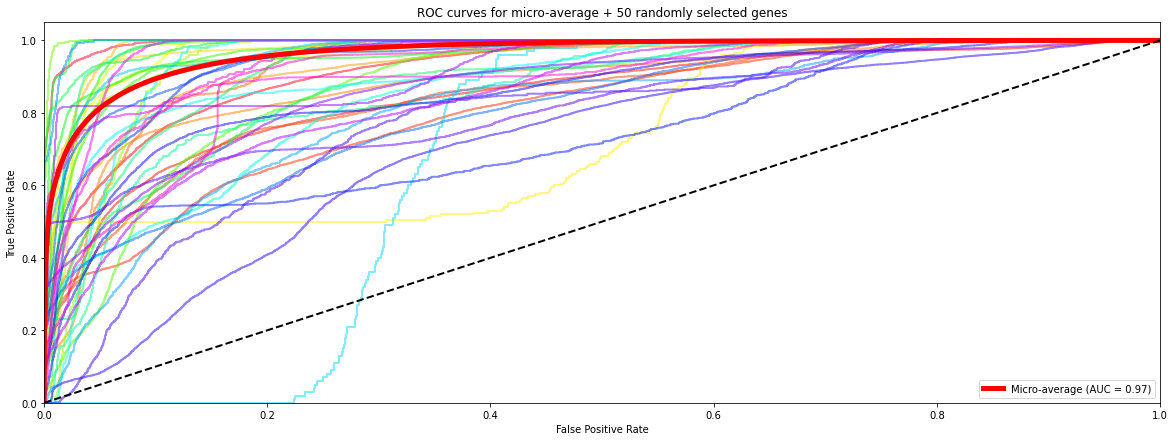

In [16]:
save_path = "/Users/natasha/Desktop/"
analyze_model.roc_curve(y_probas, target, save_path)

In [63]:
cms, f1s, b_pred = analyze_model.confusion_mat(y_probas, target, flags.replacement_threshold)

0.9428955970005769 0.4162162162162163 0.7935109004031656


TP 5549.0 , FP 339.0 , FN 996.0 , TN 172.0


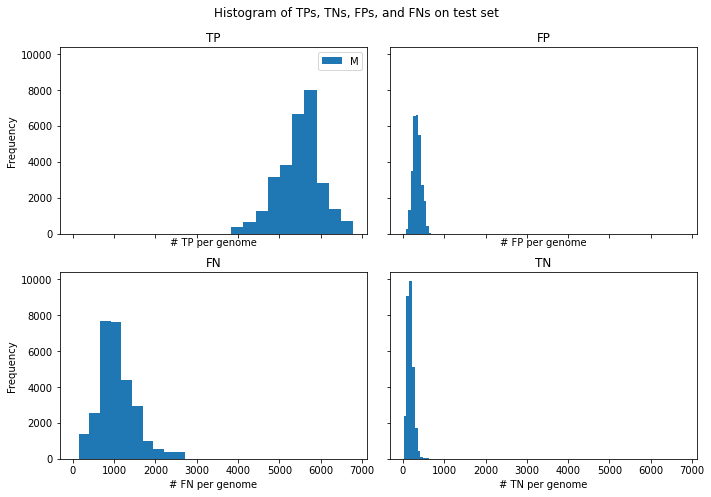

In [32]:
tp, fp, fn, tn, n_genes = analyze_model.tp_fp_fn_tn(cms)
analyze_model.cm_histogram(tp, fp, fn, tn, n_genes, num_features, settings.DATA_FP)

In [47]:
phylum_stats = analyze_model.phylum_stats(genome_to_tax, test_tax_dict, genome_idx_test, cms)

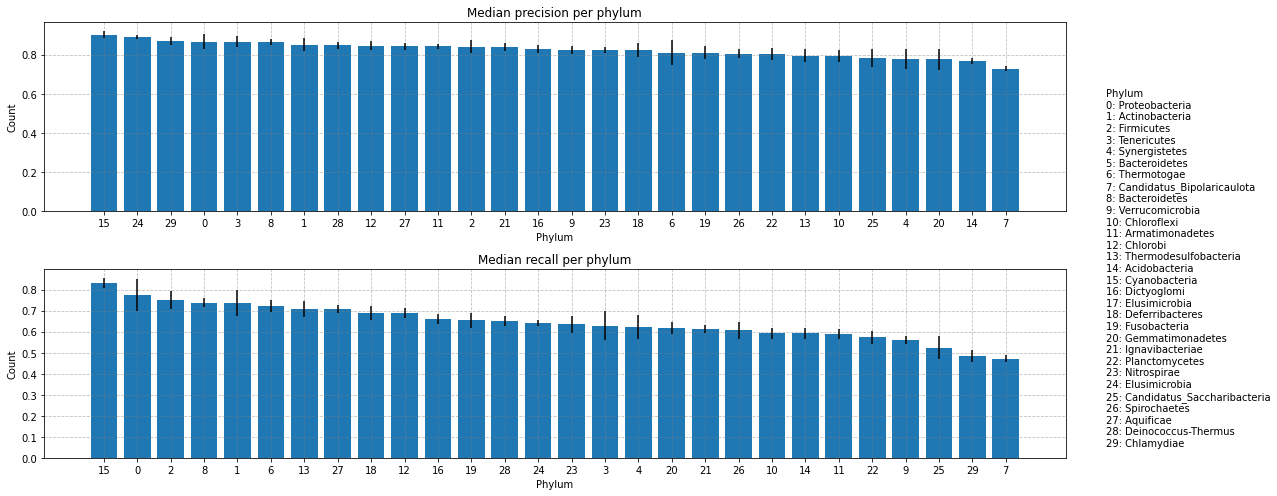

In [51]:
analyze_model.tax_cm_histogram_PR(phylum_stats, save_path)

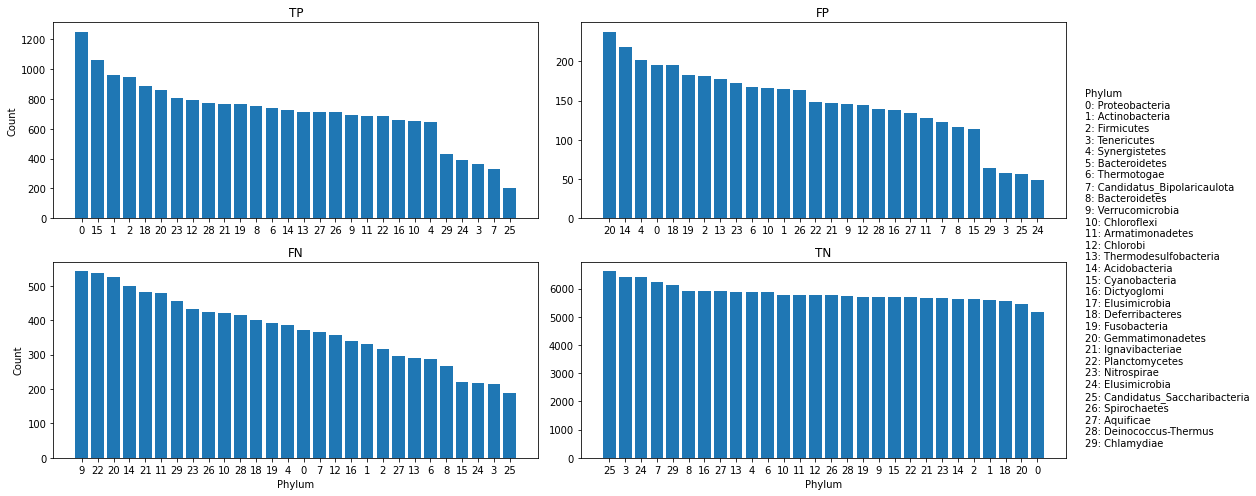

In [52]:
analyze_model.tax_cm_histogram(phylum_stats, save_path)

In [56]:
analyze_model.print_f1_per_phylum(phylum_stats)

Proteobacteria 0.81 1671.0
Actinobacteria 0.79 1299.5
Firmicutes 0.79 1273.5
Tenericutes 0.73 594.5
Synergistetes 0.7 1032.0
Bacteroidetes 0.82 1147.0
Thermotogae 0.76 1032.5
Candidatus_Bipolaricaulota 0.57 694.0
Bacteroidetes 0.8 1021.0
Verrucomicrobia 0.67 1232.0
Chloroflexi 0.68 1126.0
Armatimonadetes 0.69 1166.0
Chlorobi 0.76 1149.0
Thermodesulfobacteria 0.76 1002.0
Acidobacteria 0.67 1226.0
Cyanobacteria 0.86 1250.0
Dictyoglomi 0.73 1001.0
Elusimicrobia 0.7 786.0
Deferribacteres 0.75 1288.5
Fusobacteria 0.72 1175.0
Gemmatimonadetes 0.69 1377.5
Ignavibacteriae 0.71 1249.0
Planctomycetes 0.67 1245.0
Nitrospirae 0.72 1212.5
Elusimicrobia 0.74 605.0
Candidatus_Saccharibacteria 0.63 397.0
Spirochaetes 0.69 1138.0
Aquificae 0.77 1011.0
Deinococcus-Thermus 0.73 1190.5
Chlamydiae 0.62 883.0


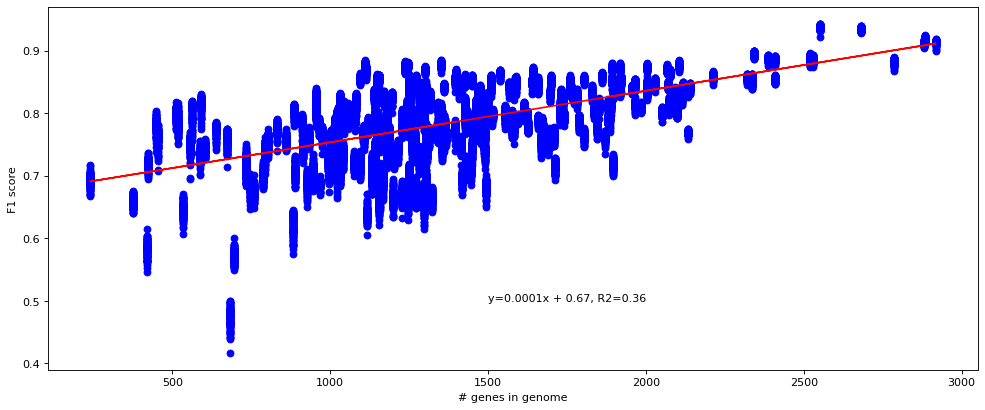

In [59]:
analyze_model.genes_f1(f1s, n_genes, save_path)

In [61]:
transporters_path = "/Users/natasha/Desktop/transporters.txt"
abx_res_path = "/Users/natasha/Desktop/abx_resistance.txt"
rps_path = "/Users/natasha/Desktop/ribosomal_proteins.txt"
b_pred_np = np.array(b_pred)

In [75]:
metab = analyze_model.pathway_perf(transporters_path, abx_res_path, rps_path)

In [77]:
analyze_model.f1_per_bright_group(metab, cluster_names, b_pred_np, target)

brite_category, median_F1, n_genes_in_group
transporters 0.6210772833723652 1815
abx_res 0.48172597005313156 128
rps 0.9947643979057591 99
central_carbon 0.8046736093472187 9
carbon_fixation 0.654189079655147 15
methane_metab 0.5273311897106109 12
nitrogen_metb 0.5676379738191111 6
sulfur_metab 0.7348837209302327 3
photosynthesis 1.0 4
atp_syn 0.7932904100304982 22


In [ ]:
# # evaluate model performance
# perf_lc = data_viz.learning_curve(train_f1_scores, test_f1_scores, "performance", flags.cirriculum)

In [ ]:
# # evaluate model performance
# optim_lc = data_viz.learning_curve(train_losses, test_losses, "optimization", flags.cirriculum)

In [ ]:
# # first convert test_data from subset -> tensor, split corrupt vs target sets
# tensor_test_data = torch.tensor([i.numpy() for i in test_data]).float()
# corrupt_test_data = tensor_test_data[:,:num_features]
# target = tensor_test_data[:,num_features:].detach().numpy()

In [ ]:
# # Generate probabilities for ROC curve
# model.eval()
# with torch.no_grad():
#     y_probas = model(corrupt_test_data) # predicted probabilities generated by model

In [ ]:
# roc = data_viz.my_roc_curve(target, y_probas.numpy())

In [ ]:
# util.log_results(roc, optim_lc, perf_lc, flags, model)

In [ ]:
# # create embeddings for test set
# #uncorrupt_test_data = tensor_test_data[:,len(cluster_names):]
# #tensor_test_data = torch.tensor([i.numpy() for i in test_data]).float()
# embeddings = train_test.generate_embeddings(model, corrupt_test_data)

In [ ]:
#data_viz.plot_tSNE(embeddings, test_data, num_to_genome, genome_to_tax, test_tax_dict)

In [ ]:
# # tSNE for corrupted genomes passed through untrained model
# untrained_model = models.AutoEncoder(len(cluster_names))
# untr_embeddings = train_test.generate_embeddings(untrained_model, corrupt_test_data)

In [ ]:
#data_viz.plot_tSNE(untr_embeddings, test_data, num_to_genome, genome_to_tax, test_tax_dict)
# data_viz.plot_tSNE(untr_embeddings, test_data, num_to_genome, genome_to_tax, genome_idx_test)

In [ ]:
# # Evaluate model and compare against baselines
# # Get corrupted input set, target set, and predictions set (binarized to 1's and 0's)
# #corrupt_test_data = tensor_test_data[:,:len(cluster_names)]

# model.eval()
# with torch.no_grad():
#     pred = model.forward(corrupt_test_data).detach().numpy()
# b_pred = train_test.binarize(pred, flags.replacement_threshold)

In [ ]:
# # Generate confusion matrix
# cm = evaluate.dom_confusion_matrix(b_pred, target, num_to_genome, genome_to_tax, test_tax_dict, genome_idx_test)

In [ ]:
# util.log_results(roc, optim_lc, perf_lc, flags, model, cm)

In [ ]:
# # Baseline 1: untrained DAE
# # Generate predictions using an untrained DAE model
# model.eval()
# with torch.no_grad():
#     untr_pred = untrained_model.forward(corrupt_test_data).detach().numpy()
# untr_b_preds = train_test.binarize(untr_pred, flags.replacement_threshold)

In [ ]:
# # if os.path.isfile(settings.DATA_FP+"rand_b_pred.pt"):
# #     print("Loading random predictions from file")
# #     rand_b_pred = torch.load(settings.DATA_FP+"rand_b_pred.pt")
# # else: 
# #     # This is slow
# #     print("Generating random predictions, this will take a while (~30 min)")
# #     rand_b_pred = evaluate.generate_baseline(num_features, train_data, 
# #                                              corrupt_test_data, "base_random", cluster_names)
# #     torch.save(rand_b_pred, settings.DATA_FP+"rand_b_pred.pt")

# rand_b_pred = evaluate.generate_baseline(num_features, train_data, 
#                                          corrupt_test_data, "base_random", cluster_names)

In [ ]:
# torch.save(rand_b_pred, settings.DATA_FP+"rand_b_pred.pt")

In [ ]:
# # if os.path.isfile(settings.DATA_FP+"smart_b_pred.pt"):
# #     print("Loading smart random predictions from file")
# #     smart_b_pred = torch.load(settings.DATA_FP+"smart_b_pred.pt")
# # else:
# #     print("Generating smart random predictions, this will take a while (~30 min)")
# #     smart_b_pred = evaluate.generate_baseline(num_features, train_data, 
# #                                           corrupt_test_data, "smart_random", cluster_names)
# #     torch.save(smart_b_pred, settings.DATA_FP+"smart_b_pred.pt")

# smart_b_pred = evaluate.generate_baseline(num_features, train_data, 
#                                       corrupt_test_data, "smart_random", cluster_names)

In [ ]:
# torch.save(smart_b_pred, settings.DATA_FP+"smart_b_pred.pt")

In [ ]:
# import numpy as np
# np.sum(smart_b_pred == rand_b_pred), np.sum(smart_b_pred != rand_b_pred)

In [ ]:
# import pandas as pd
# hs = evaluate.hamming(target, b_pred)
# hs_stats = [round(sum(hs)/len(hs),2), round(min(hs),2), round(max(hs),2)]

# untr_hs = evaluate.hamming(target, untr_b_preds)
# untr_hs_stats = [round(sum(untr_hs)/len(untr_hs),2), round(min(untr_hs),2), round(max(untr_hs),2)]

# rand_hs = evaluate.hamming(target, rand_b_pred)
# rand_hs_stats = [round(sum(rand_hs)/len(rand_hs),2), round(min(rand_hs),2), round(max(rand_hs),2)]

# smart_hs = evaluate.hamming(target, smart_b_pred)
# smart_hs_stats = [round(sum(smart_hs)/len(smart_hs),2), round(min(smart_hs),2), round(max(smart_hs),2)]


# hamming_df = pd.DataFrame([hs_stats, untr_hs_stats, rand_hs_stats, smart_hs_stats], columns=['mean', 'min', 'max'], 
#                             index=["DAE trained", "DAE untrained", "Random chance", "Smart random chance"])
# hamming_df

In [ ]:
# sys.stdout.flush()
# sys.stderr.flush()